# Get anomaly indicators

In [1]:
import yaml
import json
import pickle
import os
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from matplotlib.patches import Patch



from fault_management_uds.utilities import seed_everything
from fault_management_uds.modelling.models import load_model_checkpoint
from fault_management_uds.data.dataset import load_data, get_sensor_dataset
from fault_management_uds.synthetic.synthetic_generator import AnomalyHandler, find_unterrupted_sequences


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta


from fault_management_uds.data.load import import_metadata



2024-12-19 09:52:01.614 | INFO     | fault_management_uds.config:<module>:15 - PROJ_ROOT path is: /work3/s194262/GitHub/fault_management_uds


In [2]:
metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
# load the sensor ranges
with open(REFERENCE_DIR / 'sensor_ranges.json', 'r') as f:
    sensor_ranges = json.load(f)

#### Steps:

- Inject anomalies into test data
- Predict
- Save an observations prediction error and target value

## Load model

In [80]:
# select a folder
experiment_folder_name = 'lstm'
experiment_name = 'lr=0.0005_hidden_size=64_num_layers=1_241217_0419'
# experiment_folder_name = 'linear_regression'
# experiment_name = 'lr=0.001_241216_1718'
save_folder = MODELS_DIR / experiment_folder_name / experiment_name
print(save_folder)

# load the config
config = yaml.load(open(save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)
print(f"Total runs: {config['dataset_args']['n_splits']}") 
seed = config['training_args']['seed']
seed_everything(seed)

# run info for each split
split_info = torch.load(save_folder / 'split_info.pkl', map_location='cpu')


# get run info
split = 0
relative_path = f'{split+1}_split/'
run_info = split_info[split]    

# get the experiment to load
run_folder = save_folder / relative_path
eval_folder = run_folder / 'evaluation'

print(f"Training time: {round(run_info['training_time'], 0)} minuts")

model_to_load = 'best_model_path' # ['best_model_path', 'last_model_path']
model = load_model_checkpoint(run_folder, run_info, model_to_load, config)


Seed set to 42


/work3/s194262/GitHub/fault_management_uds/models/lstm/lr=0.0005_hidden_size=64_num_layers=1_241217_0419
Total runs: 1
Training time: 541.0 minuts
Using CPU
Model loaded from /work3/s194262/GitHub/fault_management_uds/models/lstm/lr=0.0005_hidden_size=64_num_layers=1_241217_0419/1_split/epoch=23-val_loss=0.000003.ckpt


## Load test data

In [81]:
data_type = "val"

In [82]:
data_indices = run_info['dataset_config'][f'{data_type}_index']
print(f"Data type: {data_type}, Data indices: {len(data_indices)}")
# Subset
#data_indices = data_indices[:100000]
data_indices = data_indices[:50000]

Data type: val, Data indices: 871758


In [83]:
# load the data
scalers = run_info['dataset_config']['scalers']
data = load_data([None, None], config['dataset_args']['data_file_path'], config['dataset_args'], data_type='complete')

# get a temporary dataset
dataset = get_sensor_dataset(data, config['dataset_args'], 
    data_idx=data_indices, 
    scalers=scalers,
    priority_weight=None, verbose=False, dataset_type=data_type)

# extract useful info
valid_indices = dataset.valid_indices
n_obs = len(valid_indices)
sensor_name = dataset.endogenous_vars[0] # NOTE: only one sensor is supported

del dataset

In [84]:
# Extract more info
sensor_scale = sensor_ranges[sensor_name]['clean']['range']
sensor_meta = metadata[metadata['IdMeasurement'] == sensor_name]
unit = sensor_meta['UnitAlias'].values[0]
obvious_min = sensor_meta['obvious_min'].values[0]
obvious_max = sensor_meta['obvious_max'].values[0]  


## Inject anomalies and predict

In [85]:
# load yaml file
with open(REFERENCE_DIR / 'synthetic_config.yaml', 'r') as f:
    synthetic_config = yaml.safe_load(f)

In [86]:
anomalies = list(synthetic_config['anomalies'].keys())
print(anomalies)    
severity = "medium"
# buffers are irrelevant
buffer = 0
edge_buffer = 0

['spike', 'noise', 'frozen', 'offset', 'drift']


In [87]:

def get_prediction_outputs(model, polluted_dataset, polluted_indicator, valid_indices, config):

    # Prepare columns for the results DataFrame
    columns = ['starttime', 'valid_index', 'polluted', 'target'] + model.model.returns
    results = pd.DataFrame(np.zeros((len(valid_indices), len(columns))), columns=columns)
    
    # Prepare DataLoader
    dataloader = DataLoader(
        polluted_dataset, 
        batch_size=config['training_args']['batch_size'], 
        shuffle=False, 
        num_workers=0
    )
    
    # Ensure valid_indices is a NumPy array
    valid_indices = np.array(valid_indices.cpu()) if torch.is_tensor(valid_indices) else np.array(valid_indices)
    
    # No gradient calculation during prediction
    with torch.no_grad():
        start = 0
        for batch in tqdm(dataloader, desc='Predicting'):
            x, y, _, starttime = batch
            batch_size = x.size(0)
            polluted = polluted_indicator[start:start+batch_size]
            
            # Forward pass
            prediction, final_hn = model.model.forward(x)
            # TODO: current_fix
            final_hn = final_hn.mean(dim=1) # mean over the sequence, so shape: (batch_size, hidden_size)
            #prediction = model.model.forward(x)
            
            # Save results
            results.iloc[start:start+batch_size, 0] = [pd.to_datetime(ts) for ts in starttime]
            results.iloc[start:start+batch_size, 1] = valid_indices[start:start+batch_size]
            results.iloc[start:start+batch_size, 2] = polluted
            results.iloc[start:start+batch_size, 3] = y.numpy()
            results.iloc[start:start+batch_size, 4] = prediction.numpy()
            results.iloc[start:start+batch_size, 5:] = final_hn.numpy()

            
            # Update start index
            start += batch_size

    return results

In [88]:
save_to = run_folder / 'synthetic' / data_type
save_to.mkdir(parents=True, exist_ok=True)

for anomaly in anomalies: 
    print(f"Anomaly: {anomaly}")

    # Pollute the data
    anomaly_config = synthetic_config['anomalies'][anomaly][severity]
    #anomaly_config['proportion'] = 0.01
    anomaly_handler = AnomalyHandler(anomaly_config, anomaly, sensor_name, n_obs, sensor_scale, obvious_min, obvious_max, 
                                     seed=seed, buffer=buffer, edge_buffer=edge_buffer, available_indices=valid_indices)
    
    # Inject anomalies
    anomaly_handler.initialize_injections()
    polluted_data = anomaly_handler.inject_anomalies(data)
    polluted_indicator = anomaly_handler.get_indicator()
    
    # create the dataset anew
    polluted_dataset = get_sensor_dataset(polluted_data, config['dataset_args'], 
        data_idx=data_indices, 
        scalers=scalers,
        priority_weight=None, verbose=False, dataset_type=data_type)
    
    # Get the prediction results
    results = get_prediction_outputs(model, polluted_dataset, polluted_indicator, valid_indices, config)
    # save the results
    results.to_csv(save_to / f'{anomaly}_pred_outputs.csv', index=False)
        
    break

Anomaly: spike
Total injections: 4


Predicting: 100%|██████████| 755/755 [00:30<00:00, 25.03it/s]


In [89]:
# TODO: what when outputs are vectors?

## Create outlier features

In [90]:
outputs_folder = run_folder / 'synthetic' / data_type

In [91]:
# identify analysed anomalies
anomalies = {}
for f in os.listdir(outputs_folder):
    if '_pred_outputs' in f:
        anomaly = f.split('_pred_outputs')[0]
        anomalies[anomaly] = f
anomalies

{'spike': 'spike_pred_outputs.csv'}

In [92]:
for anomaly, f in anomalies.items():
    print(f"Anomaly: {anomaly}")
    # load the outputs
    outputs = pd.read_csv(outputs_folder / f)
    break

Anomaly: spike


In [93]:
# Create the feature DataFrame

feature_df = pd.DataFrame()
feature_df['starttime'] = outputs['starttime']
feature_df['valid_index'] = outputs['valid_index']
feature_df['polluted'] = outputs['polluted']

identifier_columns = []

# Save the target
feature_df['target'] = outputs['target']
identifier_columns.append('target')

# Calculate mae
feature_df['mae'] = np.abs(outputs['prediction'] - outputs['target'])
identifier_columns.append('mae')

# Calculate the hidden states
feature_df['final_hidden'] = outputs['final_hidden']
identifier_columns.append('final_hidden')


# Finally, drop nan rows
feature_df = feature_df.dropna()
identifier_columns

['target', 'mae', 'final_hidden']

## Identify anomalies

In [ ]:
### Isolation Forest
# the contamination is the proportion of outliers in the data
iso_forest = IsolationForest(
    contamination='auto', # 0.0001 
    random_state=config['training_args']['seed']
    ).fit(feature_df[identifier_columns])

# predict the outliers
feature_df['outlier'] = iso_forest.predict(feature_df[identifier_columns])
#feature_df['outlier'] = iso_forest.predict(feature_df[identifier_columns])
# adjust to indicator
feature_df['outlier'] = feature_df['outlier'].apply(lambda x: 1 if x == -1 else 0)
# and get decision function
feature_df['decision_function'] = iso_forest.decision_function(feature_df[identifier_columns])

# classification
feature_df['outlier'].value_counts()

outlier
0    43687
1     4606
Name: count, dtype: int64

## Evaluate

- *Precision*: how many of the predicted anomalies are actual anomalies
- *Recall*: how many of the actual anomalies were predicted
- *Timing*: **accuracy** and **proximity**
    - *Start*
    - *Middle*
    - *End*
- *Anomaly Coverage*: overlap / anomaly length


In [95]:
# Define a function to categorize each prediction
def label_case(row, target='target', prediction='prediction'):
    if row[target] == 1 and row[prediction] == 1:
        return 'TP'  # True Positive
    elif row[target] == 0 and row[prediction] == 1:
        return 'FP'  # False Positive
    elif row[target] == 0 and row[prediction] == 0:
        return 'TN'  # True Negative
    elif row[target] == 1 and row[prediction] == 0:
        return 'FN'  # False Negative


# Apply the function to the DataFrame
feature_df['Outcome'] = feature_df.apply(lambda row: label_case(row, 'polluted', 'outlier'), axis=1)


#### Global

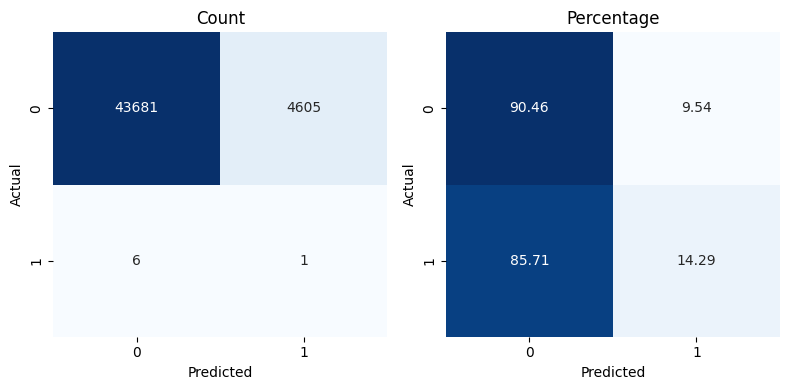

In [96]:

conf_matrix = confusion_matrix(feature_df['polluted'], feature_df['outlier'])

# Normalize the confusion matrix by row (i.e., by actual class) for percentage
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot the raw confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Count')

# Plot the confusion matrix with percentages
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Percentage')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [97]:
# Precision
precision = precision_score(feature_df['polluted'], feature_df['outlier'])
print(f"Precision: {precision*100:.2f}%")

# Recall
recall = recall_score(feature_df['polluted'], feature_df['outlier'])
print(f"Recall: {recall*100:.2f}%")

Precision: 0.02%
Recall: 14.29%


#### Individual

In [98]:
# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(feature_df['polluted'].to_list()) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

In [99]:
# Find all indices where the value is 1
ones_indices = np.where(feature_df['outlier'] == 1)[0]
# Find the closest index in both directions
if len(ones_indices) == 0:
    # do not continue
    raise ValueError("No anomalies detected")

coverage = []
timing = []

for start, end in anomaly_start_end:
    # extract relevant data
    anomaly_data = feature_df.iloc[start:end+1]
    
    # Coverage
    coverage.append(anomaly_data['outlier'].sum() / len(anomaly_data))

    # Timing
    distances = np.abs(ones_indices - start)
    closest_index = ones_indices[np.argmin(distances)]
    timing.append(closest_index - start)



print(f"Coverage: {np.mean(coverage)*100:.2f}%")
print(f"Timing: {np.mean(timing)} minutes")

Coverage: 25.00%
Timing: -31.0 minutes


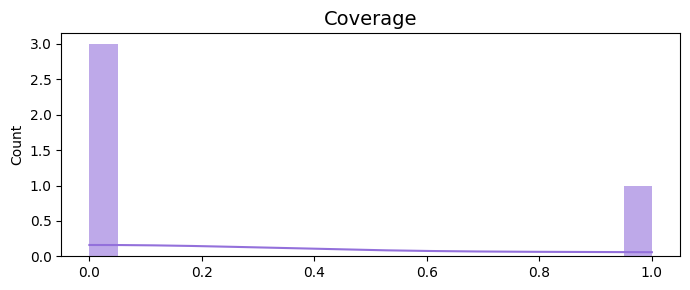

In [100]:
plt.figure(figsize=(7, 3))
sns.histplot(coverage, kde=True, color='mediumpurple', alpha=0.6, linewidth=0, bins=20)
plt.title('Coverage', fontsize=14)
plt.tight_layout()
plt.show()

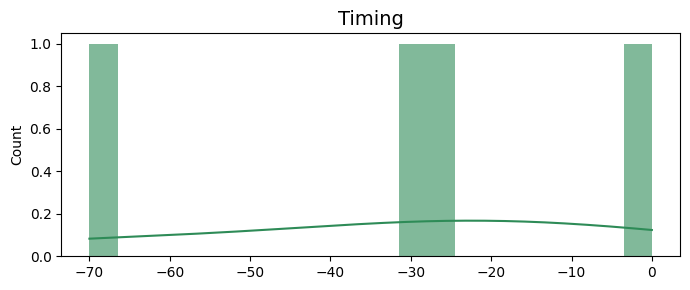

In [101]:
plt.figure(figsize=(7, 3))
sns.histplot(timing, kde=True, color='seagreen', alpha=0.6, linewidth=0, bins=20)
plt.title('Timing', fontsize=14)
plt.tight_layout()
plt.show()

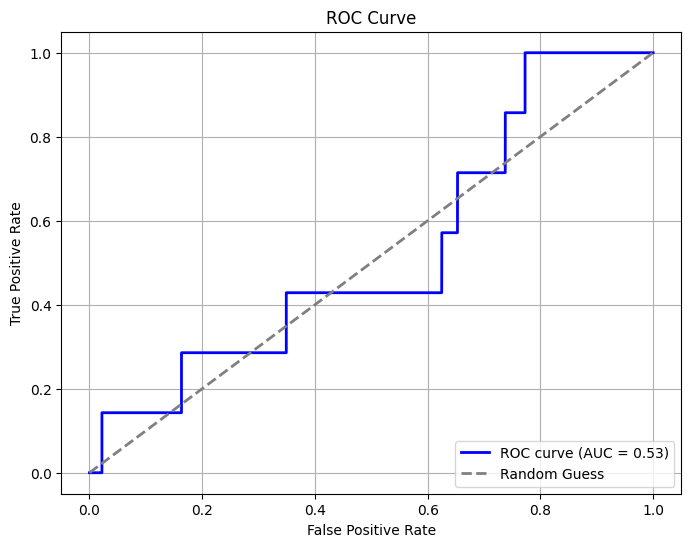

In [102]:


fpr, tpr, thresholds = roc_curve(feature_df['polluted'], -feature_df['decision_function'])
# Compute AUC score
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Interpret

#### Features

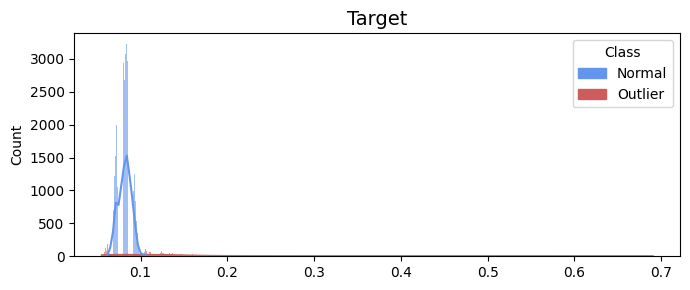

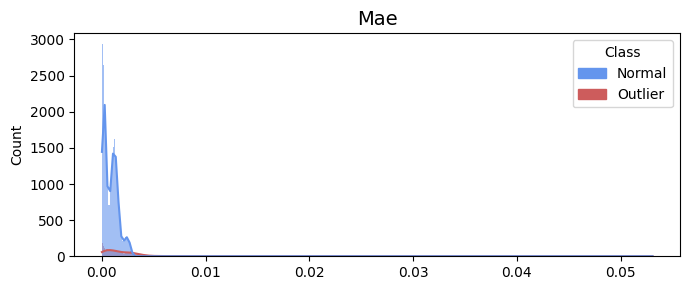

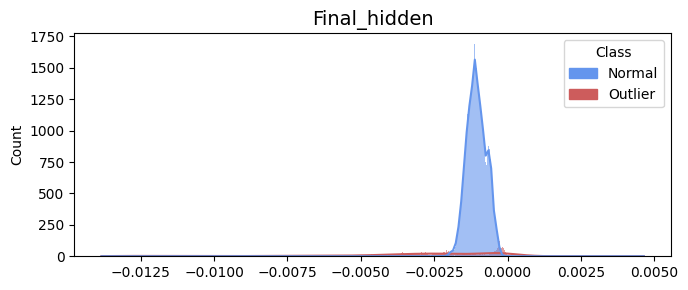

In [103]:
# Create a custom color palette (e.g., 'blue' for Normal and 'red' for Outlier)
palette = {0: 'cornflowerblue', 1: 'indianred'}  # 'Normal' will be blue, 'Outlier' will be red
classes = ['Normal', 'Outlier']
legend_handles = [Patch(color=palette[key], label=classes[key]) for key in palette.keys()]

for col in feature_df[identifier_columns].select_dtypes(include='number').columns:
    plt.figure(figsize=(7, 3))

    # Plot using 'outlier' as hue with the custom palette
    sns.histplot(data=feature_df,
        x=col, hue='outlier', kde=True, 
        palette=palette, alpha=0.6, hue_order=[0, 1],
        linewidth=0,  
        )
    
    plt.legend(legend_handles, classes, title='Class', loc='upper right') 

    plt.title(f"{col.capitalize()}", fontsize=14)
    plt.xlabel(f"")   
    plt.tight_layout()
    plt.show()


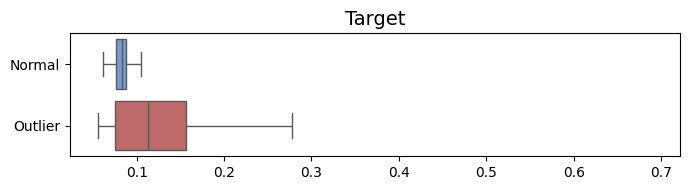

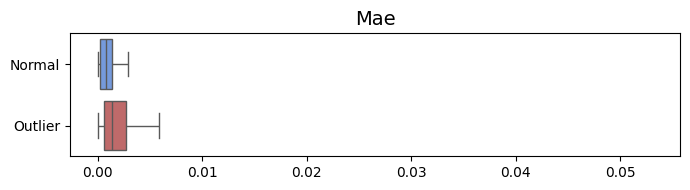

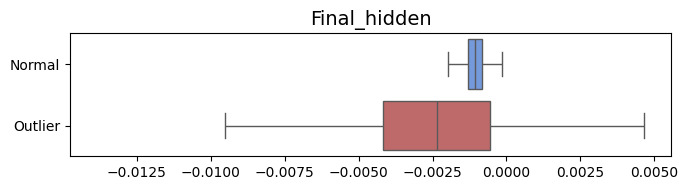

In [104]:
palette.update({str(k): v for k, v in palette.items()})

for col in identifier_columns:
    plt.figure(figsize=(7, 2))
    sns.boxplot(
        data=feature_df, x=col, y='outlier', orient='h',
        palette=palette, fliersize=0, linewidth=1, hue_order=[0, 1],
    )
    plt.title(col.capitalize(), fontsize=14)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0, 1], ['Normal', 'Outlier'])
    plt.tight_layout()
    plt.show()

#### PCA

In [105]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(feature_df[identifier_columns])

# Apply PCA
n_components = min(3, len(identifier_columns))
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_scaled)

# DataFrame with the PCA components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
# add the outcome
pca_df['Outcome'] = feature_df['Outcome'].values

# Get the loadings (components)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to match feature-column structure
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],  
    index=feature_df[identifier_columns].columns  
)

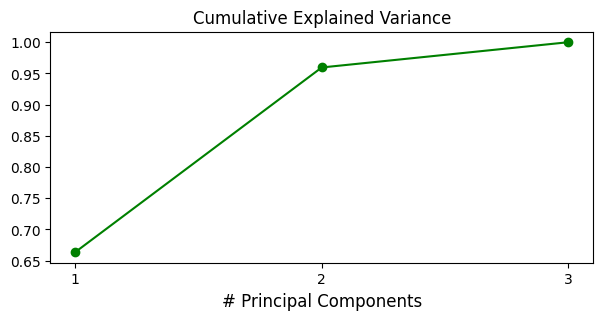

In [106]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(7, 3))
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', color='green')
plt.title('Cumulative Explained Variance')
plt.xlabel('# Principal Components', fontsize=12)
plt.xticks(np.arange(1, len(explained_variance) + 1))
#plt.grid(True)
plt.show()

In [107]:
hue_map = {
    'TP': 'darkblue',  
    'FN': 'firebrick', 
    'FP': 'navajowhite',    
    'TN': 'yellowgreen'   
}

def loading_plot(coeff, labels, scale=1, colors=None, visible=None, ax=plt, arrow_size=0.5):
    # Plot the loadings
    for i, label in enumerate(labels):
        if visible is None or visible[i]:
            ax.arrow(
                0,
                0,
                coeff[i, 0] * scale,
                coeff[i, 1] * scale,
                head_width=arrow_size * scale,
                head_length=arrow_size * scale,
                color="#000" if colors is None else colors[i],
                )
            ax.text(
                coeff[i, 0] * 1.4 * scale,
                coeff[i, 1] * 1.4 * scale,
                label,
                color="#000" if colors is None else colors[i],
                ha="center",
                va="center",
                )


def pca_plot(pca_df, x, y, hue_map):


    # Desired hue order
    hue_order = hue_map.keys()
    hue_order = list(hue_order)[::-1]

    # Example figure setup
    plt.figure(figsize=(10, 5))
    # Sort the data using np.vectorize to enforce order
    g = sns.scatterplot(
        data=pca_df.sort_values('Outcome', key=np.vectorize(hue_order.index)),  # Sort by hue_order index
        x=x, y=y, hue="Outcome", 
        hue_order=hue_order,  # Explicitly set hue_order
        palette=hue_map, alpha=0.6, s=10
    )


    # Add loadings
    loading_plot(loadings[[x, y]].values, loadings.index, scale=2, arrow_size=0.08)

    # Add variance explained by the
    g.set_xlabel(f"{x} ({explained_variance[0]*100:.2f}%)")
    g.set_ylabel(f"{y} ({explained_variance[1]*100:.2f}%)")

    # Reverse the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]
    plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(hue_map))

    plt.show()

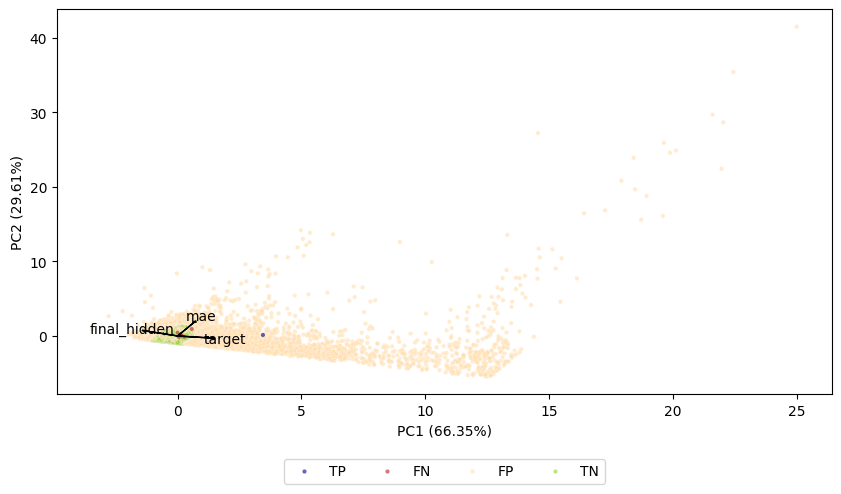

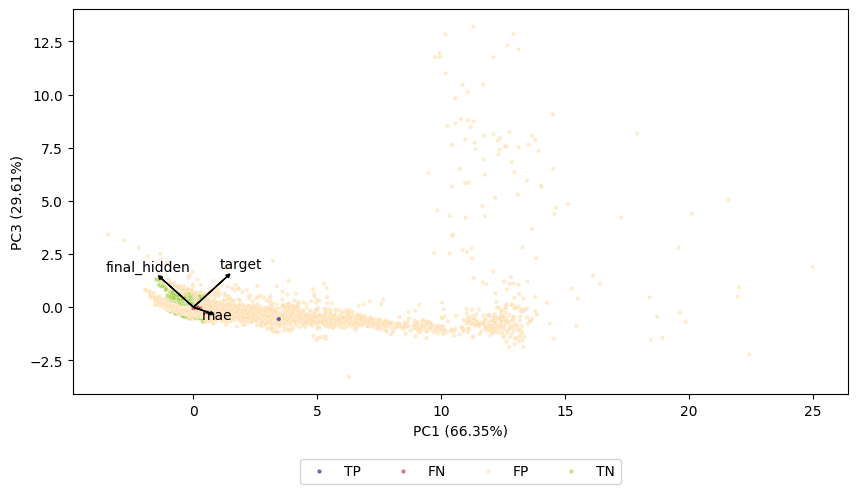

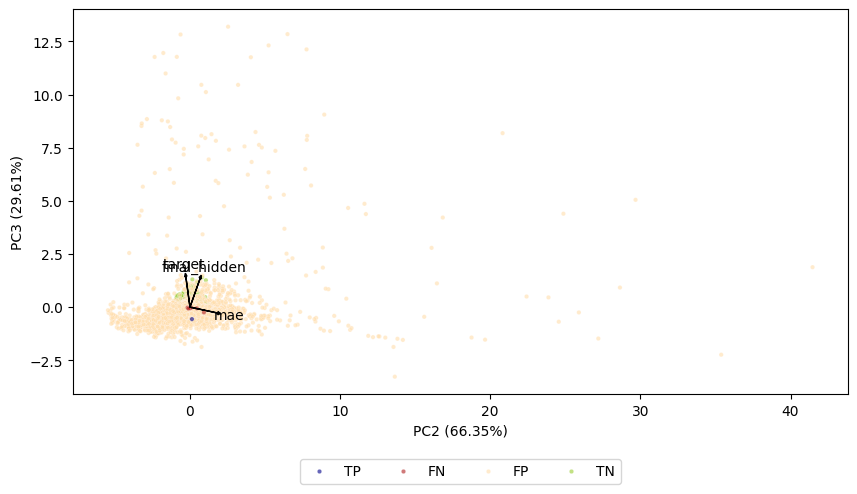

In [108]:
plot_pcs = ['PC1', 'PC2', 'PC3']
possible_pcs = [col for col in pca_df.columns if 'PC' in col]
plot_pcs = [pc for pc in plot_pcs if pc in possible_pcs]
plot_pcs = list(itertools.combinations(plot_pcs, 2))

for x, y in plot_pcs:
    pca_plot(pca_df, x, y, hue_map)

TODO: visualize some examples?
e.g.
- 2 with higher detection score, 
- and 2 that are true anomalies, 
    - classified, and not classified